# Coursera Capstone Project 
For IBM Data Science Specialization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
project_start = datetime.datetime.now()

In [3]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## Exploratory Analysis

In [4]:
df = pd.read_csv('Data-Collisions.csv')

C:\Users\kjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [6]:
df.groupby(['SEVERITYCODE', 'SEVERITYCODE.1','SEVERITYDESC'])['OBJECTID'].count()

SEVERITYCODE  SEVERITYCODE.1  SEVERITYDESC                  
1             1               Property Damage Only Collision    136485
2             2               Injury Collision                   58188
Name: OBJECTID, dtype: int64

A few fields have significant missing values, and they will be excluded from the modeling. 

In [7]:
for col in df.columns: 
    if np.mean(df[col].isnull()) > 0.4: 
        print("{:20s} {:4.2%}".format(col, np.mean(df[col].isnull())))    

INTKEY               66.57%
EXCEPTRSNCODE        56.43%
EXCEPTRSNDESC        97.10%
INATTENTIONIND       84.69%
PEDROWNOTGRNT        97.60%
SDOTCOLNUM           40.96%
SPEEDING             95.21%


In [8]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

## Data Visualization

In [9]:
def bar_plot(df, field, title, export=True): 
    df.groupby([field, 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack(level=1).plot(kind='bar', width=0.85); 
    plt.title(title);
    plt.ylabel("Record Count");
    if export: 
        plt.savefig('plot.png')

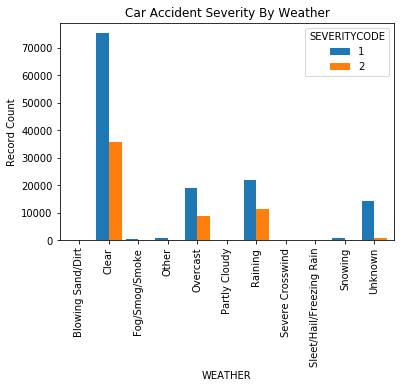

In [10]:
bar_plot(df, 'WEATHER', "Car Accident Severity By Weather")

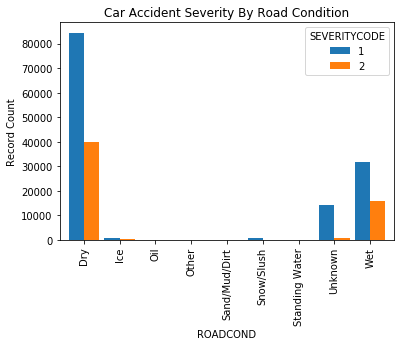

In [11]:
bar_plot(df, 'ROADCOND', 'Car Accident Severity By Road Condition')

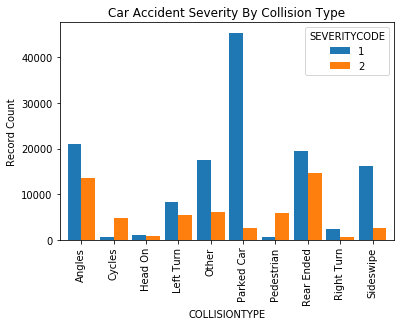

In [12]:
bar_plot(df, 'COLLISIONTYPE', 'Car Accident Severity By Collision Type')

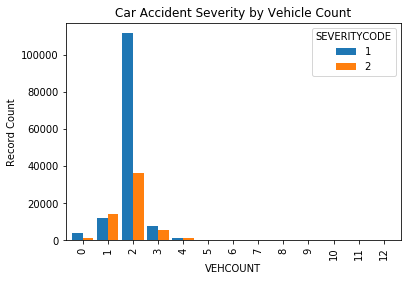

In [13]:
bar_plot(df, 'VEHCOUNT', 'Car Accident Severity by Vehicle Count')

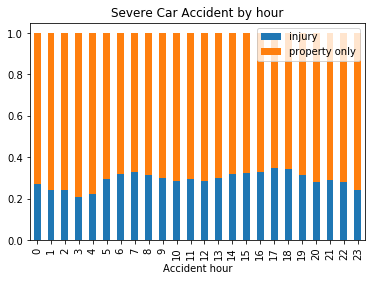

In [14]:
def by_func_or_col(func='year'):
    season_map = {1:'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 
                 7:'summer', 8:'summer', 9:'autumn', 10:'autumn', 11:'autumn', 12:'winter'}
    if func == 'year': 
        by_func = df.groupby([df['INCDTTM'].dt.year, 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack()
    elif func == 'month': 
        by_func = df.groupby([df['INCDTTM'].dt.month, 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack()
    elif func == 'hour':
        by_func = df.groupby([df['INCDTTM'].dt.hour, 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack()
    elif func == 'season': 
        df['season'] = df['INCDTTM'].dt.month.map(season_map)
        by_func = df.groupby(['season', 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack()
    elif func in features: 
        by_func = df.groupby([func, 'SEVERITYCODE'])['SEVERITYCODE'].count().unstack()
    else:
        raise ValueError("Function not recognized")
    
    by_func['total'] = by_func[1] + by_func[2]
    by_func['Property_Pct'] = by_func[1] / by_func['total']
    by_func['Injury_Pct'] = by_func[2] / by_func['total']
    by_func[[ 'Injury_Pct', 'Property_Pct']].plot.bar(stacked=True)
    plt.title("Severe Car Accident by " + func);
    plt.legend(loc='upper right', labels=['injury', 'property only'])
    plt.xlabel('Accident ' + func)
    plt.savefig('by'+func+'.png')
by_func_or_col('hour') 

## Feature selection

In [15]:
features = df.columns[15:22].append(df.columns[26:30]) ; 
features = features.drop('INCDATE')

In [16]:
df.loc[df['UNDERINFL'] == 'Y', 'UNDERINFL'] = '1'
df.loc[df['UNDERINFL'] == 'N', 'UNDERINFL'] = '0'
#by_func_or_col('UNDERINFL')

In [17]:
for col in features: 
    if df[col].dtype == "O": 
        print(df[col].value_counts())

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64
0    180668
1      9121
Name: UNDERINFL, dtype: int64
Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64
Daylight                    116137
Dark - Str

In [18]:
# df[features].dtypes
for col in features: 
    print("{:20s} {:4.2%} {:4d}".format(col, np.mean(df[col].isnull()), len(df[col].unique())))   

COLLISIONTYPE        2.52%   11
PERSONCOUNT          0.00%   47
PEDCOUNT             0.00%    7
PEDCYLCOUNT          0.00%    3
VEHCOUNT             0.00%   13
INCDTTM              0.00% 162058
UNDERINFL            2.51%    3
WEATHER              2.61%   12
ROADCOND             2.57%   10
LIGHTCOND            2.66%   10


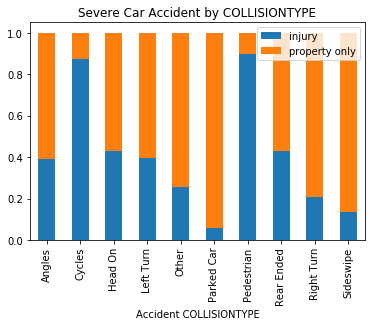

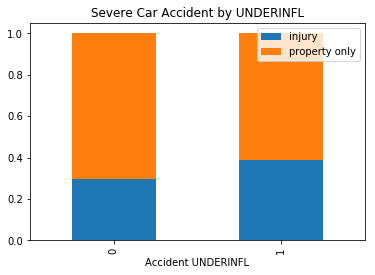

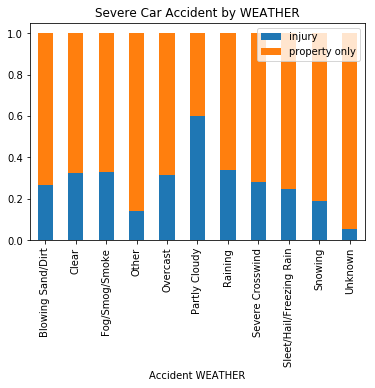

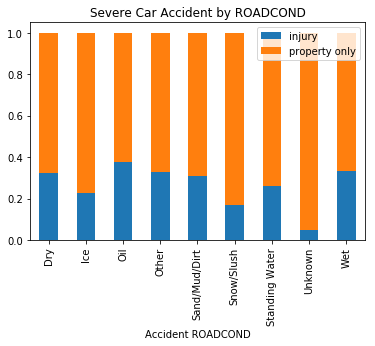

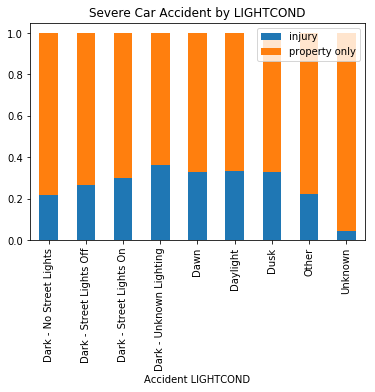

In [19]:
 for col in features: 
    if df[col].dtype == "O": 
        by_func_or_col(col)

In [20]:
selected = df[features.insert(0, 'SEVERITYCODE')]; 
#X[X.isnull().any(axis=1)]     #find rows with missing values
selected = selected.dropna(axis=0, how='any')

In [21]:
selected['UNDERINFL'] = selected['UNDERINFL'].astype(bool)

In [22]:
selected['traffic_hour'] = 0
selected.loc[selected['INCDTTM'].dt.hour.isin([6,7,8,17,18]), 'traffic_hour'] = 1

In [23]:
selected = selected.drop('INCDTTM', axis=1)

In [24]:
cols = []
for col in features: 
    if (col in selected.columns) and (selected[col].dtype == 'O'): 
        cols.append(col)

In [25]:
y = selected['SEVERITYCODE']; 
X = selected.iloc[:, 1:]

In [26]:
X = pd.get_dummies(X, columns=cols, drop_first=True); X.shape

(189316, 41)

## Modeling

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### <font color = 'blue'> KNN classification model </font>

In [29]:
from sklearn.neighbors import KNeighborsClassifier
def knn_accuracy(Ks, X, y): 
    knn_metrics = {}
    for k in Ks: 
        neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
        y_hat = neigh.predict(X)
        knn_metrics[k] = metrics.accuracy_score(y_hat, y)
        print("When K = {:2d}, KNN classifier accuracy = {:4.2f}".format(k, knn_metrics[k]))
    return knn_metrics

In [30]:
# start = datetime.datetime.now()
# knn_metrics = knn_accuracy(range(4,13), X_train, y_train)
# end = datetime.datetime.now()

In [31]:
# pd.DataFrame.from_dict(knn_metrics, orient='index', columns=['Accuracy']).plot();
# plt.title('KNN Training Accurarcy by K');
# plt.xlabel("K");
# plt.savefig('KNN accuracy.png')

KNN model with K= 6 yields the best performance.  We will proceed with this parameter.  

In [32]:
start = datetime.datetime.now()
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)
y_hat_knn = knn.predict(X_train)
print("KNN accuracy:", metrics.accuracy_score(y_hat_knn, y_train))
end = datetime.datetime.now()
print("KNN Model Training Time: ", round((end-start).seconds/60,2), 'minutes')

KNN accuracy: 0.7477235278813633
KNN Model Training Time:  9.72 minutes


### <font color = 'blue'> Decision Tree model </font>

In [33]:
from sklearn.tree import DecisionTreeClassifier
def tree_accuracy(X, y): 
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    print("Tree model accuaracy: {:4.2f}%".format(metrics.accuracy_score(y_hat, y)*100))
    return tree

In [34]:
mytree = tree_accuracy(X_train, y_train)

Tree model accuaracy: 74.84%


In [35]:
y_hat_tree = mytree.predict(X_train)
metrics.f1_score(y_hat_tree, y_train)

0.84597233012754

### <font color = 'blue'> Support Vector Machine (SVM) model </font>

In [41]:
from sklearn import svm
def svm_accuracy(X, y): 
    svm_model = svm.SVC(kernel='rbf')
    svm_model.fit(X, y)
    y_hat = svm_model.predict(X)
    print("SVM model accuaracy: {:4.2f}%".format(metrics.accuracy_score(y_hat, y)*100))
    return svm_model

In [42]:
start_svm = datetime.datetime.now()
svm_model = svm_accuracy(X_train, y_train)
end_svm = datetime.datetime.now()
print("SVM training time = {:5.2f} minutes".format((end_svm-start_svm).seconds/60))

SVM model accuaracy: 75.50%
SVM training time = 59.05 minutes


In [43]:
y_hat_svm = svm_model.predict(X_train)
print("SVM F-1 Score: {:4.2f}%".format(metrics.f1_score(y_hat_svm, y_train, average='weighted') * 100))
print("SVM Jaccard score: {:4.2f}%".format(metrics.jaccard_similarity_score(y_hat_svm, y_train) * 100))
print("SVM confusion matrix: ")
metrics.confusion_matrix(y_hat_svm, y_train)

SVM F-1 Score: 80.43%
SVM Jaccard score: 75.50%
SVM confusion matrix: 


array([[86325, 28863],
       [ 2219,  9434]], dtype=int64)

### <font color = 'blue'> Logistic Regression model </font>

In [44]:
from sklearn.linear_model import LogisticRegression
def logit_model(X, y):
    logit = LogisticRegression(C=0.01, solver='liblinear')
    logit.fit(X, y)
    y_hat = logit.predict(X)
    print("Logistic Accuracy: {:4.2f}%".format(metrics.accuracy_score(y_hat, y)*100))
    return logit

In [45]:
logit = logit_model(X_train, y_train)

Logistic Accuracy: 75.46%


### <font color = 'blue'> Random Forest model </font>

In [46]:
from sklearn.ensemble import RandomForestClassifier
def rf_model(X, y):
    rf = RandomForestClassifier(max_depth=3)
    rf.fit(X, y)
    y_hat = rf.predict(X)
    print("Random Forest Accuracy: {:4.2f}%".format(metrics.accuracy_score(y_hat, y)*100))
    return rf

C:\Users\kjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [47]:
start = datetime.datetime.now()
rf = rf_model(X_train, y_train)
end = datetime.datetime.now()
print("RF model needs ", (end-start).seconds/60, 'minutes.')

Random Forest Accuracy: 74.80%
RF model needs  0.016666666666666666 minutes.


### Summary of Metrics on Training Dataset

In [72]:
models = [knn, mytree, svm_model, logit, rf]
yhats_train = [model.predict(X_train) for model in models]

In [89]:
precision = [metrics.precision_score(y_train, yhat) for yhat in yhats_train]
recall = [metrics.recall_score(y_train, yhat) for yhat in yhats_train]
F1_score = [metrics.f1_score(y_train, yhat) for yhat in yhats_train]
accuracy = [metrics.accuracy_score(y_train, yhat) for yhat in yhats_train]

In [88]:
?metrics.recall_score

In [90]:
train_metric = pd.DataFrame({'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression', 'Random Forest'], 
                      'Precision' : precision,
                      'Recall' : recall,
                      'F1-score': F1_score, 
                      'Accuracy': accuracy})

In [95]:
train_metric.to_csv("train_metric.csv")

### Model Evaluation using Testing Dataset

In [51]:
models = [knn, mytree, svm_model, logit, rf]

In [52]:
yhats = [model.predict(X_test) for model in models]

In [92]:
#Jaccard = [metrics.jaccard_similarity_score(y_test, yhat) for yhat in yhats]
precision = [metrics.precision_score(y_test, yhat) for yhat in yhats]
recall = [metrics.recall_score(y_test, yhat) for yhat in yhats]
F1_score = [metrics.f1_score(y_test, yhat) for yhat in yhats]
accuracy = [metrics.accuracy_score(y_test, yhat) for yhat in yhats]

In [93]:
report = pd.DataFrame({'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression', 'Random Forest'], 
                      'Precision' : precision,
                      'Recall' : recall,
                      'F1-score': F1_score, 
                      'Accuracy': accuracy})

In [96]:
report.to_csv('test_report.csv')

In [56]:
project_end = datetime.datetime.now()
print("project run time: {:5.2f} minutes".format((project_end-project_start).seconds/60))

project run time: 273.13 minutes
